#**Mask Detection Model**

###**Importing Libraries**

In [5]:
# import the libraries as shown below
from keras.models import Sequential
from keras.layers import Conv2D, Input, Activation, MaxPooling2D, Flatten, Dense,Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator,load_img
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#### Connecting GDrive

In [14]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# creating an environment in GDrive
import os
os.environ['KAGGLE_CONFIG_DIR']='/content/gdrive/My Drive/kaggle_dataset'

### **Importing data from kaggle**

In [ ]:
%cd /content/gdrive/My Drive/kaggle_dataset

/content/gdrive/My Drive/kaggle_dataset


In [ ]:
!ls

kaggle.json  mask-detection


In [ ]:
!kaggle datasets download -d ashishjangra27/face-mask-12k-images-dataset

 99% 328M/330M [00:02<00:00, 160MB/s]
100% 330M/330M [00:02<00:00, 166MB/s]


In [ ]:
!mkdir mask-detection
!mv face-mask-12k-images-dataset.zip mask-detection

mkdir: cannot create directory ‘mask-detection’: File exists


In [ ]:
%cd mask-detection/

/content/gdrive/My Drive/kaggle_dataset/mask-detection


In [ ]:
#unzipping the data
!unzip face-mask-12k-images-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Face Mask Dataset/Train/WithoutMask/1855.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1856.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1857.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1858.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1859.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1860.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1861.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1862.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1863.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1864.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1865.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1866.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1867.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1868.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1869.png  
  inflating: Face Mask Dataset/Train/WithoutMask/

### **Data Preprocessing**

In [5]:
#saving image path
train_path = '/content/gdrive/MyDrive/kaggle_dataset/mask-detection/Face Mask Dataset/Train'
valid_path = '/content/gdrive/MyDrive/kaggle_dataset/mask-detection/Face Mask Dataset/Validation'

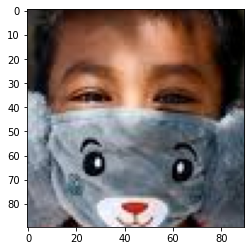

In [ ]:
#displaying image from google drive
img=mpimg.imread('/content/gdrive/MyDrive/kaggle_dataset/mask-detection/Face Mask Dataset/Train/WithMask/1511.png')
plt.imshow(img)
plt.show()

In [6]:
# Checking number of outputs
folders = glob('/content/gdrive/MyDrive/kaggle_dataset/mask-detection/Face Mask Dataset/Train/*')
folders

['/content/gdrive/MyDrive/kaggle_dataset/mask-detection/Face Mask Dataset/Train/WithMask',
 '/content/gdrive/MyDrive/kaggle_dataset/mask-detection/Face Mask Dataset/Train/WithoutMask']

In [15]:
TRAINING_PATH = "/content/gdrive/MyDrive/kaggle_dataset/mask-detection/Face Mask Dataset/Train"
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(TRAINING_PATH, 
                                                    batch_size=10, 
                                                    target_size=(150, 150))
VALIDATION_PATH = "/content/gdrive/MyDrive/kaggle_dataset/mask-detection/Face Mask Dataset/Validation"
validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_PATH, 
                                                         batch_size=10, 
                                                         target_size=(150, 150))

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


### **Hyperparameter Tuning**

In [7]:
#creating a function
def build_model(hp):  
  model = keras.Sequential([
    Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        activation='relu',
        input_shape=(150,150,3)
    ),
    MaxPooling2D(
        pool_size=hp.Choice('max_kernel_1', values = [2,3])
    ),
    Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        activation='relu'
    ),
    MaxPooling2D(
        pool_size=hp.Choice('max_kernel_2', values = [2,3])
    ),
    Flatten(),
    Dropout(0.5),
    Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
        activation='relu'
    ),
    Dense(2, activation='softmax')
  ])
  
  model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-3, 1e-4])),
              loss='binary_crossentropy',
              metrics=['accuracy'])
  
  return model

In [11]:
#make sure kerastuner is installed
!pip install keras-tuner

     |████████████████████████████████| 71kB 5.7MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp37-none-any.whl size=78938 sha256=771e03a2616e058fb3795c3abe343bb82ba8aadf8b31aac5d3d106e1904fcdfa
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp37-none-any.whl size=15356 sha256=3295d1a5a37c33c249e6b43d64b24c5443c4756f2a49073fe939b5fdbdf6dd48
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [12]:
#using RandomSearch
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

In [ ]:
tuner_search=RandomSearch(build_model,
                          objective='accuracy',
                          max_trials=5,directory='output',project_name='face_mask_detection')

In [ ]:
tuner_search.search(train_generator,epochs=3)

Trial 5 Complete [00h 03m 18s]
accuracy: 0.9347000122070312

Best accuracy So Far: 0.9347000122070312
Total elapsed time: 01h 33m 18s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner_search.results_summary()

Results summary
Results in output/face_mask_detection
Showing 10 best trials
Objective(name='accuracy', direction='max')
Trial summary
Hyperparameters:
conv_1_filter: 64
conv_1_kernel: 3
max_kernel_1: 3
conv_2_filter: 48
conv_2_kernel: 3
max_kernel_2: 3
dense_1_units: 64
learning_rate: 0.0001
Score: 0.9347000122070312
Trial summary
Hyperparameters:
conv_1_filter: 112
conv_1_kernel: 5
max_kernel_1: 2
conv_2_filter: 32
conv_2_kernel: 5
max_kernel_2: 3
dense_1_units: 80
learning_rate: 0.0001
Score: 0.9333999752998352
Trial summary
Hyperparameters:
conv_1_filter: 96
conv_1_kernel: 3
max_kernel_1: 3
conv_2_filter: 48
conv_2_kernel: 5
max_kernel_2: 3
dense_1_units: 80
learning_rate: 0.0001
Score: 0.932699978351593
Trial summary
Hyperparameters:
conv_1_filter: 64
conv_1_kernel: 5
max_kernel_1: 3
conv_2_filter: 32
conv_2_kernel: 3
max_kernel_2: 2
dense_1_units: 80
learning_rate: 0.001
Score: 0.9316999912261963
Trial summary
Hyperparameters:
conv_1_filter: 96
conv_1_kernel: 5
max_kernel_1: 2
co

### **Creating Model**

In [7]:
model = Sequential([
    Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(3,3),
    
    Conv2D(48, (3,3), activation='relu'),
    MaxPooling2D(3,3),
    
    Flatten(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')
])
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 48)        27696     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 48)        0         
_________________________________________________________________
flatten (Flatten)            (None, 10800)             0         
_________________________________________________________________
dropout (Dropout)            (None, 10800)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                6

In [12]:
r=model.fit(train_generator,validation_data=validation_generator,epochs=10)

Epoch 1/10
1000/1000 [==============================] - 2813s 3s/step - loss: 0.3632 - acc: 0.8435 - val_loss: 0.1319 - val_acc: 0.9575
Epoch 2/10
1000/1000 [==============================] - 80s 80ms/step - loss: 0.2065 - acc: 0.9218 - val_loss: 0.1217 - val_acc: 0.9600
Epoch 3/10
1000/1000 [==============================] - 79s 79ms/step - loss: 0.1986 - acc: 0.9192 - val_loss: 0.0937 - val_acc: 0.9700
Epoch 4/10
1000/1000 [==============================] - 79s 79ms/step - loss: 0.1679 - acc: 0.9332 - val_loss: 0.1144 - val_acc: 0.9600
Epoch 5/10
1000/1000 [==============================] - 79s 79ms/step - loss: 0.1677 - acc: 0.9374 - val_loss: 0.0815 - val_acc: 0.9762
Epoch 6/10
1000/1000 [==============================] - 79s 79ms/step - loss: 0.1532 - acc: 0.9435 - val_loss: 0.0989 - val_acc: 0.9663
Epoch 7/10
1000/1000 [==============================] - 79s 79ms/step - loss: 0.1426 - acc: 0.9441 - val_loss: 0.0828 - val_acc: 0.9750
Epoch 8/10
1000/1000 [==========================

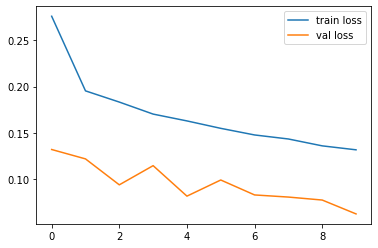

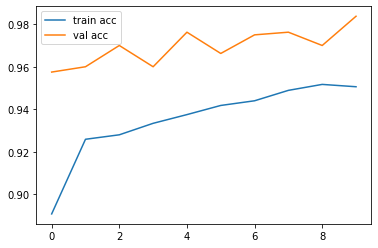

<Figure size 432x288 with 0 Axes>

In [26]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['acc'], label='train acc')
plt.plot(r.history['val_acc'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

### **Saving the model**

In [16]:
saveloc = "/content/gdrive/MyDrive/Colab Notebooks/mask_detector.h5"
model.save(saveloc)
print("Model saved to: " + saveloc + " succesfully.")

Model saved to: /content/gdrive/MyDrive/Colab Notebooks/mask_detector.h5 succesfully.
